In [12]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Load the final dataset
df = pd.read_csv('../data/processed/final_dataset.csv')


In [29]:
# Define mapping from rating to group
rating_to_group = {
    'Aaa': 'Prime',
    'Aa1': 'High Grade', 'Aa2': 'High Grade', 'Aa3': 'High Grade',
    'A1': 'Upper Mid', 'A2': 'Upper Mid', 'A3': 'Upper Mid',
    'Baa1': 'Lower Mid', 'Baa2': 'Lower Mid', 'Baa3': 'Lower Mid',
    'Ba1': 'Speculative', 'Ba2': 'Speculative', 'Ba3': 'Speculative',
    'B1': 'Speculative', 'B2': 'Speculative', 'B3': 'Speculative',
    'Caa1': 'High Risk', 'Caa2': 'High Risk', 'Caa3': 'High Risk',
    'Ca': 'High Risk', 'C': 'High Risk'
}

# Create the 'rating_group' column
df['rating_group'] = df['rating'].map(rating_to_group)

# Encode rating group into ordinal buckets
rating_group_order = [['High Risk', 'Speculative', 'Lower Mid', 'Upper Mid', 'High Grade', 'Prime']]
encoder = OrdinalEncoder(categories=rating_group_order)
df['rating_encoded'] = encoder.fit_transform(df[['rating_group']])

# Define features and target
features = df.drop(columns=[
    'country_cleaned', 'rating', 'rating_group', 'rating_action_date', 'rating_year', 'rating_encoded'
])
target = df['rating_encoded']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target
)

In [30]:
# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)



In [31]:
# Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.60      0.67         5
         1.0       0.57      0.80      0.67        10
         2.0       0.33      0.25      0.29         4
         3.0       1.00      0.50      0.67         4
         4.0       1.00      0.50      0.67         2
         5.0       0.67      1.00      0.80         2

    accuracy                           0.63        27
   macro avg       0.72      0.61      0.63        27
weighted avg       0.67      0.63      0.62        27




Confusion Matrix:


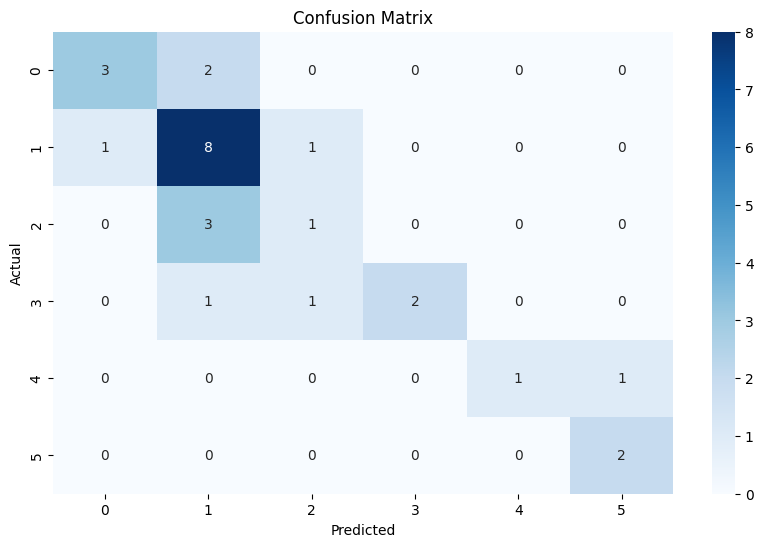

In [32]:
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [33]:
import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save classifier
joblib.dump(clf, '../models/rating_bucket_classifier.joblib')

# Save encoder
joblib.dump(encoder, '../models/rating_group_encoder.joblib')


['../models/rating_group_encoder.joblib']

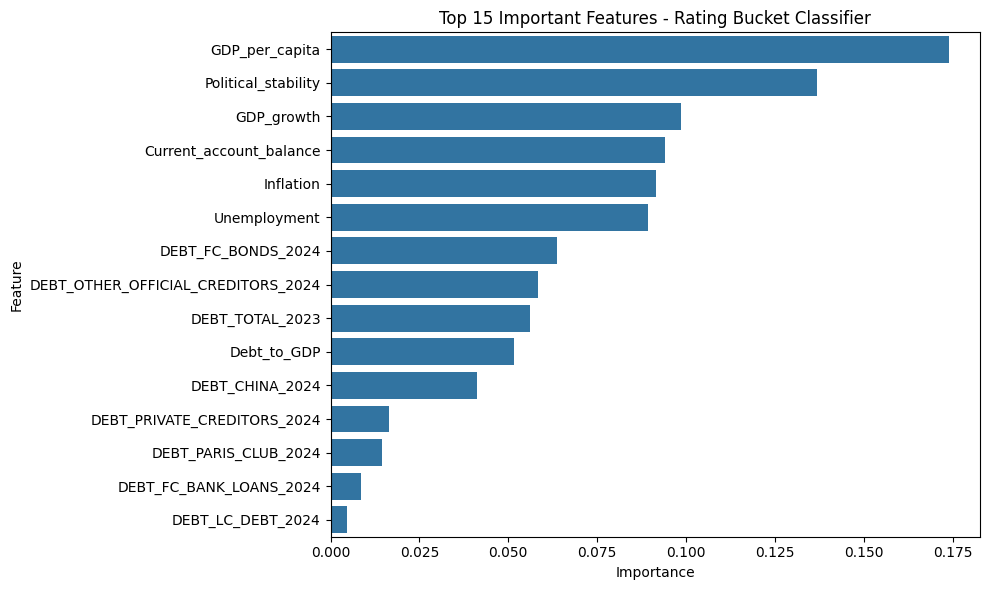

In [34]:

# Get feature importances
importances = clf.feature_importances_
feature_names = X_train.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot top N important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(15))
plt.title('Top 15 Important Features - Rating Bucket Classifier')
plt.tight_layout()
plt.show()


In [35]:
### Prepare for regression model
# Define features for regression (excluding 'rating_encoded')

# Reuse the cleaned features (without rating_encoded)
target_reg = df['rating_encoded']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    features, target_reg, test_size=0.2, random_state=42
)


In [36]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train_reg, y_train_reg)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [37]:
y_pred_reg = regressor.predict(X_test_reg)


In [40]:
from math import sqrt

mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = sqrt(mse)



In [41]:
r2 = r2_score(y_test_reg, y_pred_reg)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

RMSE: 0.7103
R² Score: 0.7039


In [42]:

# Round to nearest class
y_pred_rounded = np.round(y_pred_reg)

print("Classification Report (Rounded Predictions):")
print(classification_report(y_test_reg, y_pred_rounded))


Classification Report (Rounded Predictions):
              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80         6
         1.0       0.54      0.88      0.67         8
         2.0       0.60      0.60      0.60         5
         3.0       1.00      0.40      0.57         5
         4.0       1.00      0.67      0.80         3
         5.0       0.00      0.00      0.00         0

    accuracy                           0.67        27
   macro avg       0.69      0.53      0.57        27
weighted avg       0.79      0.67      0.68        27



c:\Users\HP\anaconda3\envs\sovereign_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\HP\anaconda3\envs\sovereign_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\HP\anaconda3\envs\sovereign_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


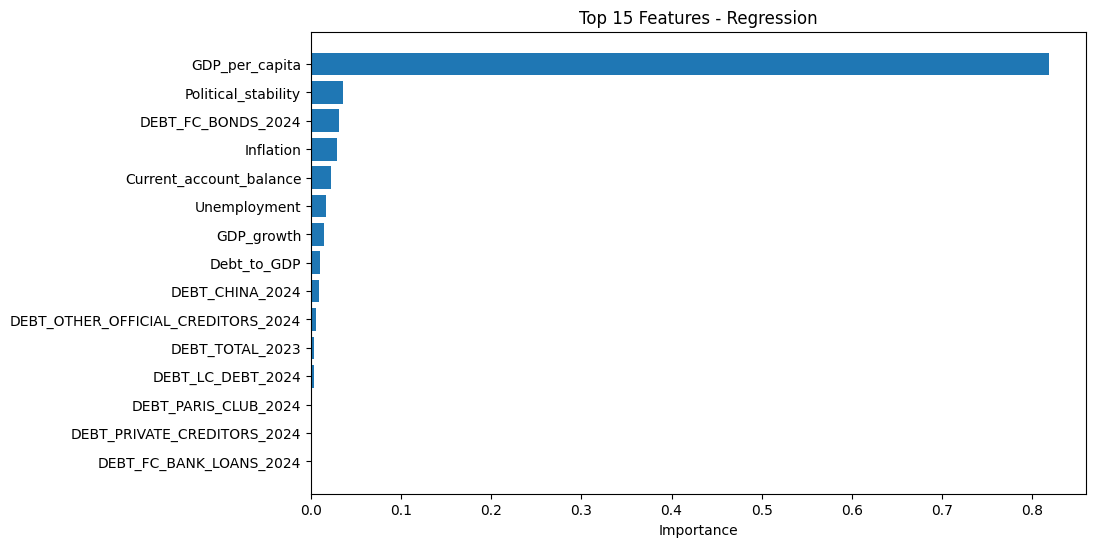

In [43]:
importances = regressor.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': features.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Importance")
plt.title("Top 15 Features - Regression")
plt.gca().invert_yaxis()
plt.show()
